In [0]:

import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial


In [2]:

folder_id = '1ivriiYfFZvEyCW1gkyQE8abuUpCdejKY' # Enter the last part of the URL of the Google Drive folder here

!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': '\'' + folder_id + "\' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)
  
os.chdir(local_download_path)

title: corners.mat, id: 1lQpGf2mCO13_0GLObxnI5WTkY8A3nFFY
downloading to /root/data/corners.mat
title: keble_a.jpg, id: 115opcvOm8m3yjXeTejRwwuyU1sAZkGOQ
downloading to /root/data/keble_a.jpg
title: keble_b.jpg, id: 1ZZ1cSP0rUmXfn_aK5gZsgjSPBVBlbJJB
downloading to /root/data/keble_b.jpg
title: keble_c.jpg, id: 1CptLTqgFTXAC7YokkO8L-d54gbuCArkV
downloading to /root/data/keble_c.jpg
title: sift_features.mat, id: 15QHuB9oMBipOaSYwRqNaKIXi84OXThTp
downloading to /root/data/sift_features.mat
title: download.png, id: 1QKNKBvg1Ku_hhHpNmOg_lh3ScZOkUYpj
downloading to /root/data/download.png
title: images.jpeg, id: 1aStJuMZbYbHxgEwaH56ypj-9PKlRf-vO
downloading to /root/data/images.jpeg
title: a.jpg, id: 1dtGJyyxEGQfO6teVtarOU9H3Tfbh2vzO
downloading to /root/data/a.jpg
title: paper.jpg, id: 1ynjFVeJEHIDiRHtEyedoTxGpSdp0w22C
downloading to /root/data/paper.jpg
title: paper.jpeg, id: 1WbiGpI_3wwCiuj34pZfaKWUGA6uMmo1w
downloading to /root/data/paper.jpeg
title: cameraman.tif, id: 1FFssDwy1W333sxtmh

In [0]:

class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def matchfeatures(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Perform ratio test: d(fa, fb1) / d(fa, fb2) 
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
def to_kpts(pts, size=1):
  return [cv2.KeyPoint(pt[0], pt[1], size) for pt in pts]
  

def computeH(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices holding the (x,y)
  locations of n(= 4) point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix, which will correspond to the smallest singular value, and thus the least error
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()
  


In [0]:

def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):
    '''
    ALGORITHM for RANSAC
    H = eye(3,3); nBest = 0;
    for (int i = 0; i < nIterations; i++) #Repeat for nRANSAC iterations:
            {
              P4 = SelectRandomSubset(P); #Choose a minimal set of feature matches.
              Hi = ComputeHomography(P4); #Estimate the transformation implied by these matches
              nInliers = ComputeInliers(Hi); #count the number of inliers.
              if (nInliers > nBest)
                  {
                    H = Hi;                  
                     nBest = nInliers;
                   }
              }
     
    '''
      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
             
          
        H_estimate=computeH(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = ComputeInliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      
    M=computeH(im1_pts,im2_pts)
    return M




In [0]:

def ComputeInliers(f1, f2, matches, H, RANSACthresh):
  '''
  Transform the matched features in f1 by H. Store the match index of features in f1 for which the transformed
  feature is within Euclidean distance RANSACthresh of its match in f2
  '''      

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    transformedQueryFeature = H.dot(queryPoint) 

   
    comp1 = [transformedQueryFeature[0]/transformedQueryFeature[2], transformedQueryFeature[1]/transformedQueryFeature[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def ImageBounds(img, H):
    """
    This function takes the image and the transformation 
    and gives out the box bounding the image after applying the H
    """
    h, w= img.shape[0], img.shape[1]
    p1 = np.dot(H, np.array([0, 0, 1]))
    p2 = np.dot(H, np.array([0, h - 1, 1]))
    p3 = np.dot(H, np.array([w - 1, 0, 1]))
    p4 = np.dot(H, np.array([w - 1, h - 1, 1]))
    x1 = p1[0] / p1[2]
    y1 = p1[1] / p1[2]
    x2 = p2[0] / p2[2]
    y2 = p2[1] / p2[2]
    x3 = p3[0] / p3[2]
    y3 = p3[1] / p3[2]
    x4 = p4[0] / p4[2]
    y4 = p4[1] / p4[2]
    minX = math.ceil(min(x1, x2, x3, x4))
    minY = math.ceil(min(y1, y2, y3, y4))
    maxX = math.ceil(max(x1, x2, x3, x4))
    maxY = math.ceil(max(y1, y2, y3, y4))

    return int(minX), int(minY), int(maxX), int(maxY)
  
  
def Image_accumulate(img, accumulator, H, bw):
  
    '''
    This function is to resample each image to its final location 
    This is done using  inverse mapping here then and blend it with its neighbors
    To reduce discontinuities in intensity and color
    between the images being composited, use a  simple feathering
    algorithm, i.e., we weight the pixels in each image proportionally
    to their distance to the edge (or more precisely, their distance to the
    nearest invisible pixel
    '''

    h, w = img.shape[0], img.shape[1]
    minX, minY, maxX, maxY = ImageBounds(img, H)

    for i in range(minX, maxX + 1):
        for j in range(minY, maxY + 1):
            p = np.dot(np.linalg.inv(H), np.array([i, j, 1]))

            x = p[0]
            y = p[1]
            z = p[2]

            _x = int(x / z)
            _y = int(y / z)

            if _x < 0 or _x >= w - 1 or _y < 0 or _y >= h - 1:
                continue

            if img[_y, _x, 0] == 0 and img[_y, _x, 1] == 0 and img[_y, _x, 2] == 0:
                continue

            wt = 1.0

            if _x >= minX and _x < minX + bw:
                wt = float(_x - minX) /bw
            if _x <= maxX and _x > maxX -bw:
                wt = float(maxX - _x) /bw

            accumulator[j, i, 3] += wt

            for c in range(3):
                accumulator[j, i, c] += img[_y, _x, c] *wt


  

In [0]:

def Image_Stitch(Imagesall, blendWidth, accWidth, accHeight, translation):
    channels=3
    width=720

    acc = np.zeros((accHeight, accWidth, channels + 1))
    M = np.identity(3)
    for count, i in enumerate(Imagesall):
        M = i.position
        img = i.img
        M_trans = translation.dot(M)
        Image_accumulate(img, acc, M_trans, blendWidth)
    
    height, width = acc.shape[0], acc.shape[1]

    img = np.zeros((height, width, 3))
    for i in range(height):
        for j in range(width):
            weights = acc[i, j, 3]
            if weights > 0:
                for c in range(3):
                    img[i, j, c] = int(acc[i, j, c] / weights)
                    

    Imagefull = np.uint8(img)
    M = np.identity(3)
    for count, i in enumerate(Imagesall):
        if count != 0 and count != (len(Imagesall) - 1):
            continue

        M = i.position

        M_trans = translation.dot(M)

        p = np.array([0.5 * width, 0, 1])
        p = M_trans.dot(p)

        
        if count == 0:
            x_init, y_init = p[:2] / p[2]
        
        if count == (len(Imagesall) - 1):
            x_final, y_final = p[:2] / p[2]
    
    
    A = np.identity(3)
    croppedImage = cv2.warpPerspective(
        Imagefull, A, (accWidth, accHeight), flags=cv2.INTER_LINEAR
    )
    displayplot(croppedImage, 'Final Stitched Image')



(200,)


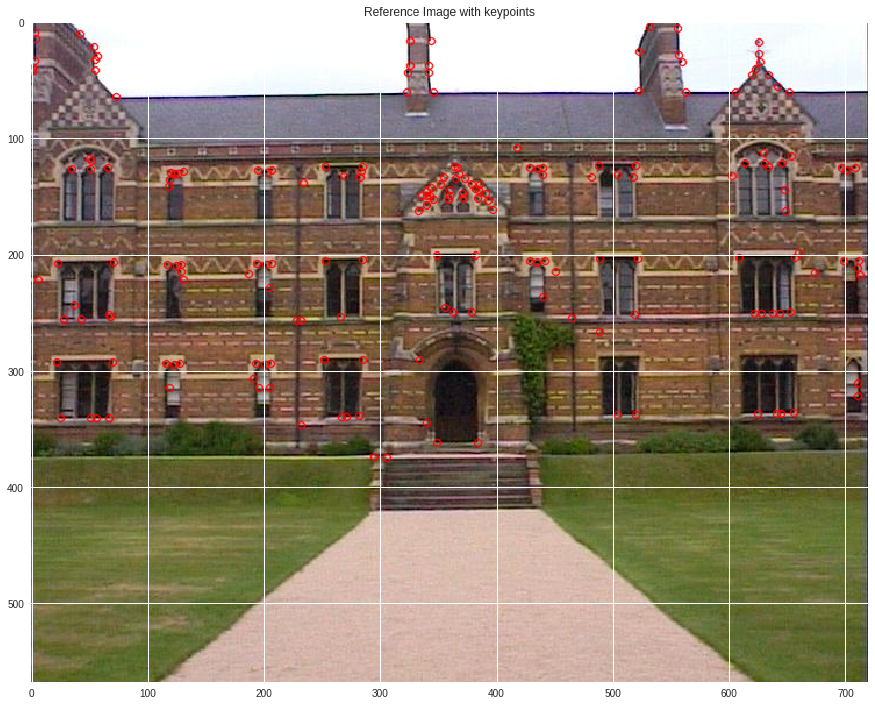

Number of matches 19


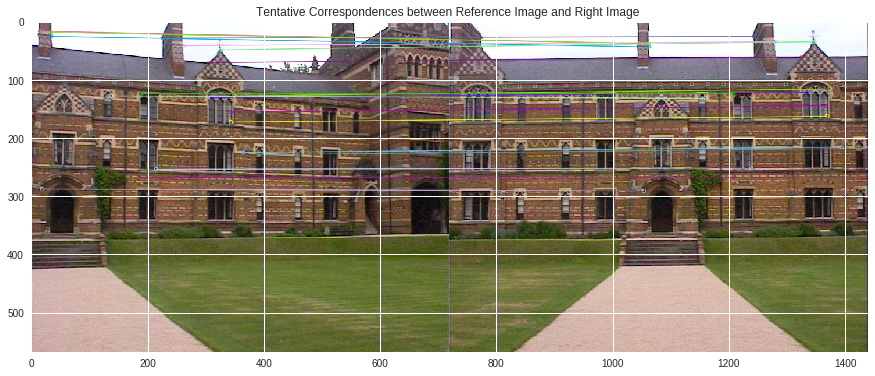

Numberof matches 15


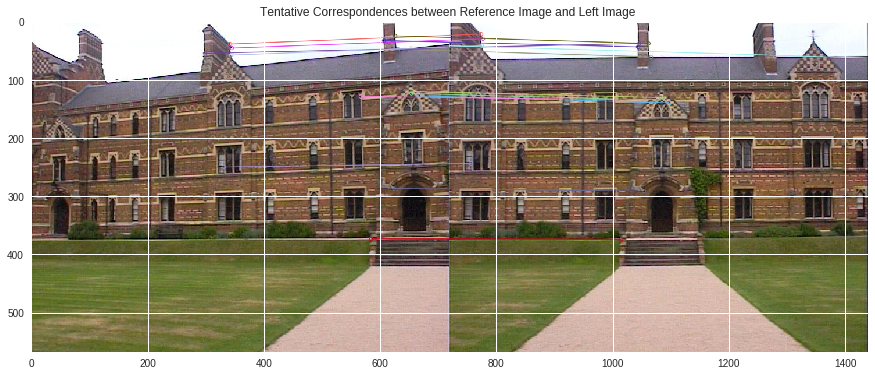

Number of best inliers 17


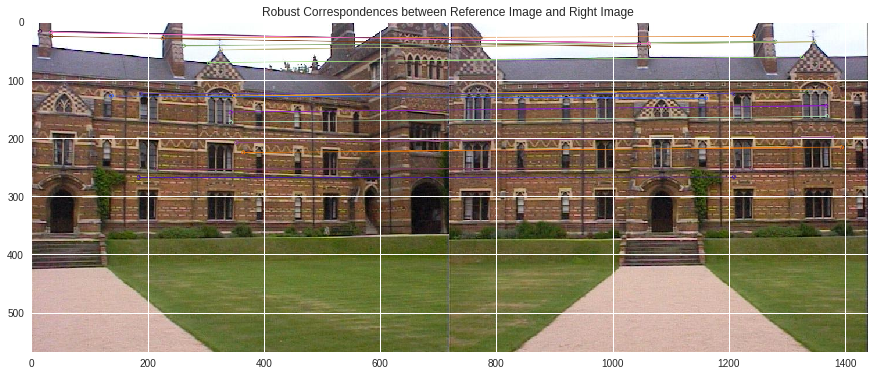

Number of best inliers 13


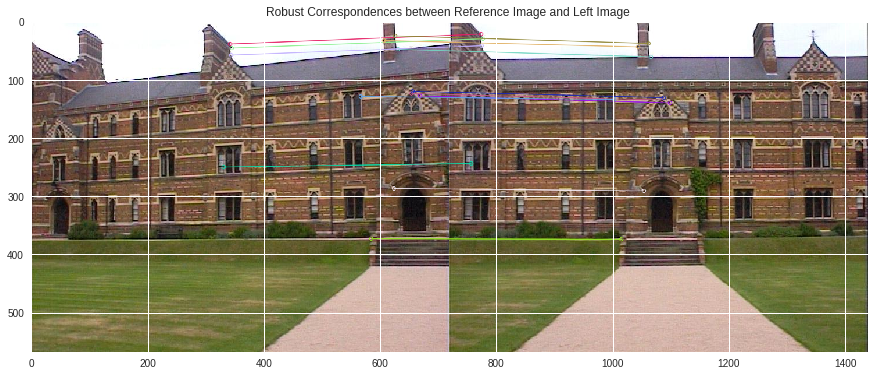

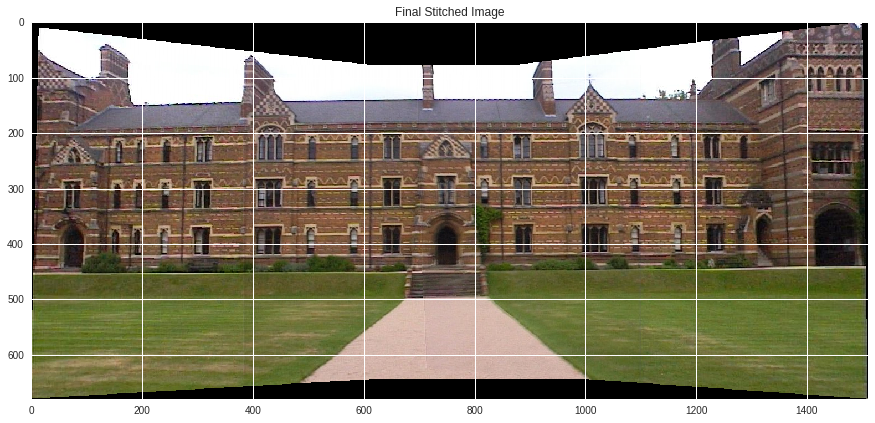

In [7]:

def main():
  
    #Loading and storing the feature points
    mat = scipy.io.loadmat('corners.mat')
    
    data1 = mat.get('corners_left')
    lp = np.array(data1)    
       
    data3 = mat.get('corners_center')
    cp= np.array(data3)
    
    data2 = mat.get('corners_right')
    rp = np.array(data2)
    
    #Loading and storing the desriptors
    mat = scipy.io.loadmat('sift_features.mat')
    data1 = mat.get('sift_left')
    lf = np.array(data1)    
    data2 = mat.get('sift_right')
    rf = np.array(data2)    
    data3 = mat.get('sift_center')
    cf= np.array(data3)
    
    # Choose a reference image
    left = cv2.imread('keble_a.jpg')
    centre = cv2.imread('keble_b.jpg')
    right = cv2.imread('keble_c.jpg')
   
    #Changing the array values to cv2.Keypoint class form 
    lpkey=to_kpts(lp)
    cpkey=to_kpts(cp)
    rpkey=to_kpts(rp)
    print(np.shape(lpkey))
    
    #Display the keypoints
    im_with_keypoints = cv2.drawKeypoints(centre, cpkey, np.array([]), (0,0,255))   
    displayplot(im_with_keypoints,'Reference Image with keypoints')
    
    # Euclidean distance to compute pairwise distances between the SIFT descriptors of refernce image and right image
    p=scipy.spatial.distance.cdist(rf,cf, metric='sqeuclidean') 
    matches1=matchfeatures(p,200,0.2)
    print("Number of matches",len(matches1))
    dispimg1=cv2.drawMatches( right, rpkey,centre, cpkey,matches1, None,flags=2)
    displayplot(dispimg1,'Tentative Correspondences between Reference Image and Right Image ')
     
    
    
    # Euclidean distance to compute pairwise distances between the SIFT descriptors of refernce image and left image
    p=scipy.spatial.distance.cdist(lf,cf, metric='sqeuclidean') 
    matches2=matchfeatures(p,200,0.2)
    print("Numberof matches",len(matches2))
    dispimg2=cv2.drawMatches(left, lpkey,centre, cpkey, matches2, None,flags=2)
    displayplot(dispimg2,'Tentative Correspondences between Reference Image and Left Image ')
    
    
    # Estimate homography 1
    #Compute H1
    im1_pts=np.empty((18,2))
    im2_pts=np.empty((18,2))
    for i in range(0,18):
      m = matches1[i]
      (a_x, a_y) = rpkey[m.queryIdx].pt
      (b_x, b_y) = cpkey[m.trainIdx].pt
      im1_pts[i]=(a_x, a_y)
      im2_pts[i]=(b_x, b_y)    
    H=computeH(im1_pts,im2_pts) 
    #Robustly estimate Homography 1 using RANSAC
    H1=RANSAC_alg(rpkey ,cpkey, matches1,  nRANSAC=90, RANSACthresh=1)    
    global inlier_matchset   
    dispimg1=cv2.drawMatches(right, rpkey, centre, cpkey, inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Correspondences between Reference Image and Right Image ')
    
    
    # Estimate homography 2
    #Compute H2
    im1_pts=np.empty((10,2))
    im2_pts=np.empty((10,2))
    for i in range(0,10):
      m = matches2[i]
      (a_x, a_y) = lpkey[m.queryIdx].pt
      (b_x, b_y) = cpkey[m.trainIdx].pt
      im1_pts[i]=(a_x, a_y)
      im2_pts[i]=(b_x, b_y)
    H=computeH(im1_pts,im2_pts) 
    #Robustly estimate Homography 2 suing RANSAC  
    H2=RANSAC_alg(lpkey ,cpkey, matches2,  nRANSAC=100, RANSACthresh=2.0)
    dispimg2=cv2.drawMatches(left, lpkey, centre, cpkey,inlier_matchset, None,flags=2)
    displayplot(dispimg2,'Robust Correspondences between Reference Image and Left Image ')
    
       
   
    H1=H1/H1[2,2]
    H2=H2/H2[2,2]
    
    I1=Image(left,H2)    
    I2=Image(centre,np.eye(3))   
    I3=Image(right,H1)
    Imagesall=[I1,I2,I3]
    #Calculating the final width,height of image the minimum width,height such that all tranformed images lie within accumulator
    
    minX = sys.maxsize
    minY = sys.maxsize
    maxX = 0
    maxY = 0
    
    M = np.identity(3)
    for i in Imagesall:
        M = i.position
        img = i.img
        _minX, _minY, _maxX, _maxY = ImageBounds(img, M) 
        minX = min(minX, _minX)
        minY = min(minY, _minY)
        maxX = max(maxX, _maxX)
        maxY = max(maxY, _maxY)
        
    accWidth = int(math.ceil(maxX) - math.floor(minX))
    accHeight = int(math.ceil(maxY) - math.floor(minY))
    #transformation matrix so that top-left corner of accumulator image is origin
    
    translation = np.array([[1, 0, -minX], [0, 1, -minY], [0, 0, 1]])
    Image_Stitch([I1,I2,I3],1000,accWidth, accHeight,  translation)    
    
    
main()

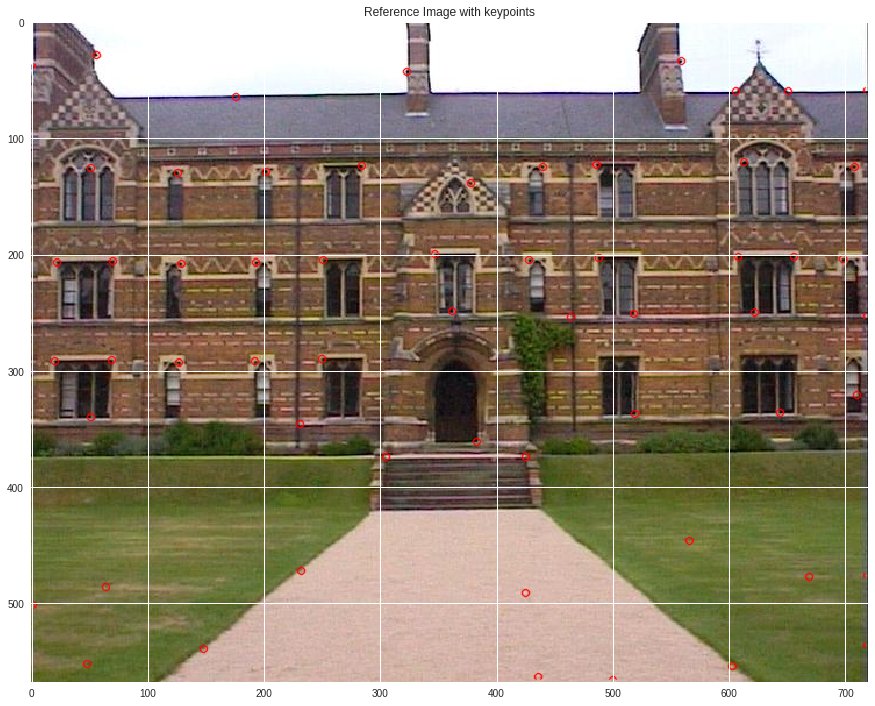

In [31]:


def main():
  
    # Choose a reference image
    left = cv2.imread('keble_a.jpg')
    centre = cv2.imread('keble_b.jpg')
    right = cv2.imread('keble_c.jpg')
   
    #Changing the array values to cv2.Keypoint class form 
    lpkey=detectKeypoints(left) 
    cpkey=detectKeypoints(centre) 
    rpkey=detectKeypoints(right) 
    
   
    #Display the keypoints
    im_with_keypoints = cv2.drawKeypoints(centre, cpkey, np.array([]), (0,0,255))   
    displayplot(im_with_keypoints,'Reference Image with keypoints')
    
main()